## Categorising countries

### Data Source

The data used in this task was orginally sourced from Help.NGO. This international non-governmental organisation specialises in emergency response, preparedness, and risk mitigation.  

### Dataset Attributes
- country: name of the country
- child_mort: death of children under 5 years of age per 1000 live births
- exports: exports of goods and services per capita. Given as a percentage of the GDP per capita
- health: total health spending per capita. Given as a percentage of GDP per capita
- imports: imports of goods and services per capita. Given as a percentage of the GDP per capita
- income: net income per person
- inflation: the measurement of the annual growth rate of the Total GDP
- life_expec: the average number of years a new born child would live if the current mortality patterns remain the same
- total_fer: the number of children that would be born to each woman if the current age-fertility rates remains the same
- gdpp: the GDP per capita. Calculated as the Total GDP divided by the total population.

## Objective  
To group countries using socio-economic and health factors to determine the development status of the country.

In [304]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [305]:
# Random state seed
rseed = 42

## Load and explore data

In [306]:
# Import the dataset
df = pd.read_csv('Country-data.csv')

In [307]:
# Check the shape
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [308]:
# Check datatypes & counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [309]:
# Get descriptive statistics
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [310]:
# Identify any missing data
df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

## Preprocessing and Feature Selection

In [311]:
# Drop any non-numeric features (columns)
df.drop('country', axis=1, inplace=True)

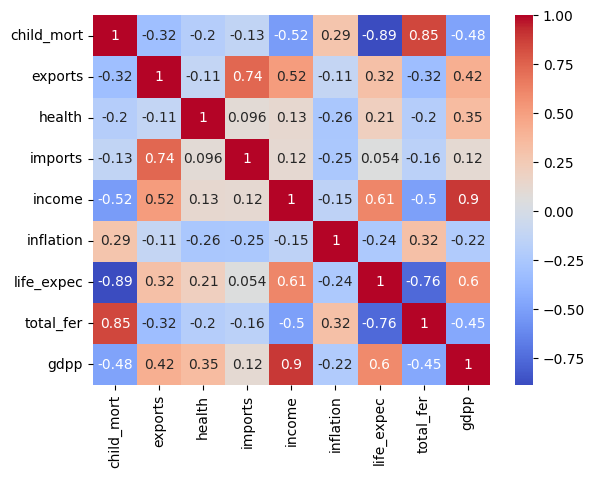

In [312]:
# Create a correlation map of features to explore relationships between features
# Hint: Explore seaborn heatmap
dataplot = sns.heatmap(df.corr(), cmap="coolwarm", annot=True) 
plt.show()

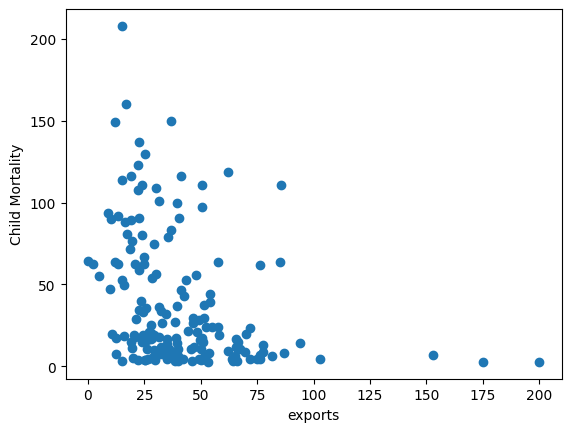

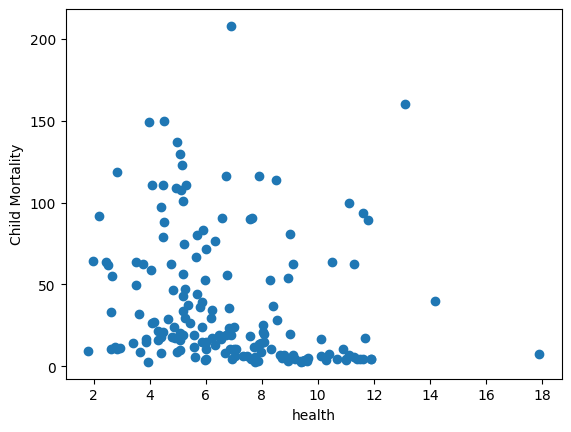

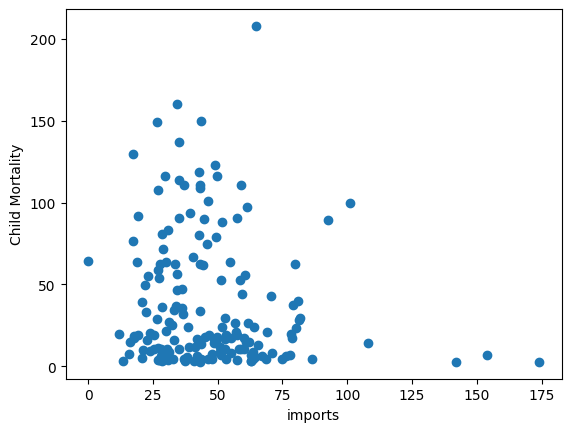

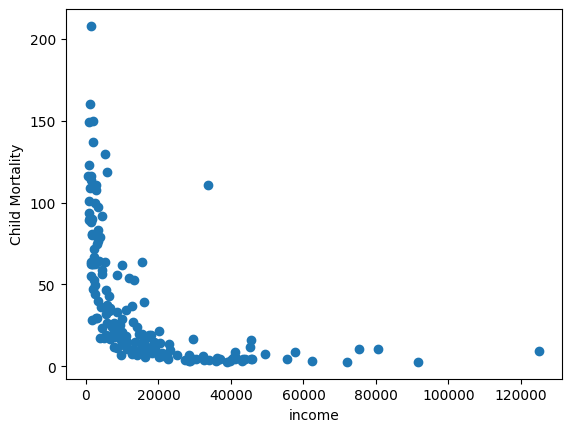

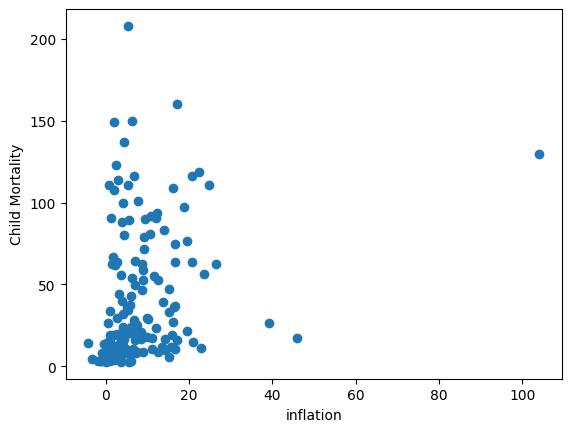

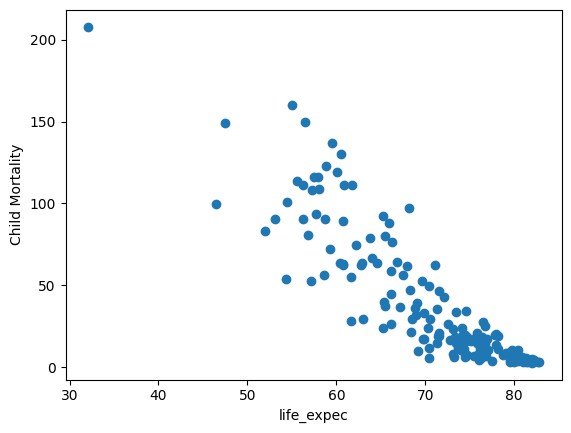

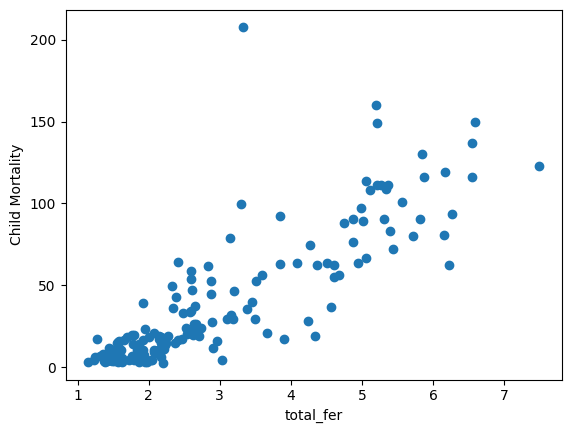

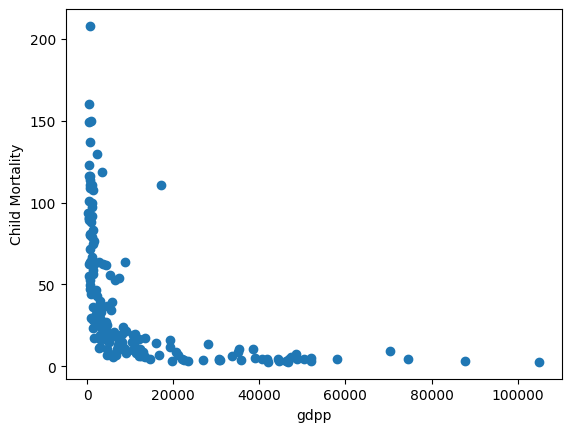

In [313]:
# Explore the continuous independent features against child_mort using scatter plots.
for f in df.columns[1:]:  # Exclude 'child_mort'
  plt.scatter(df[f], df['child_mort'])
  plt.xlabel(f)
  plt.ylabel('Child Mortality')
  plt.show()

Of these plots, it seems like total_fer, imports and health appear to be the most promising for separating into meaningful clusters.

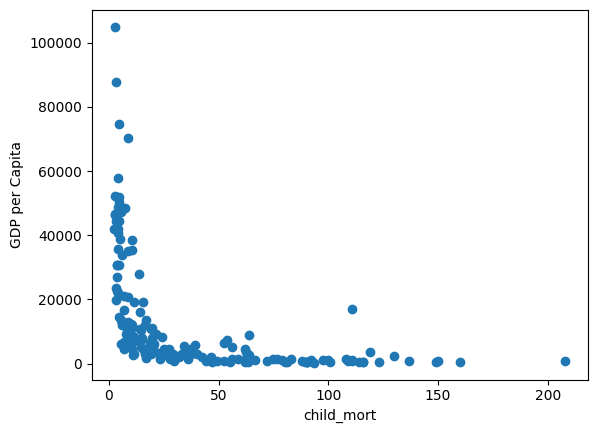

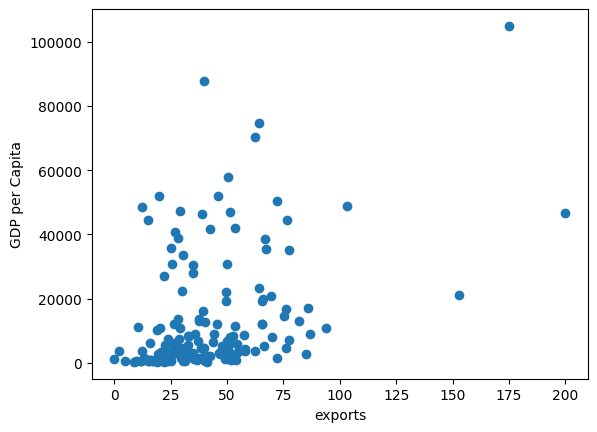

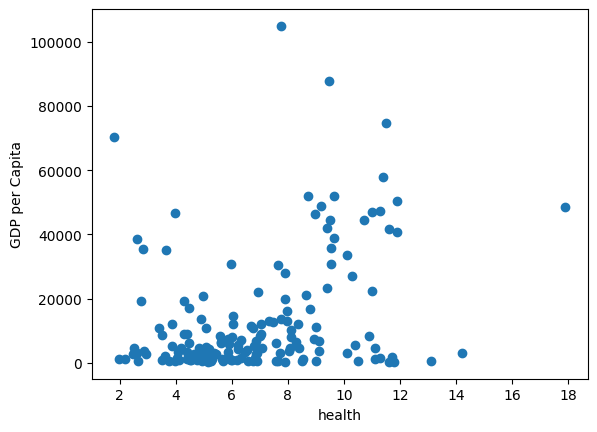

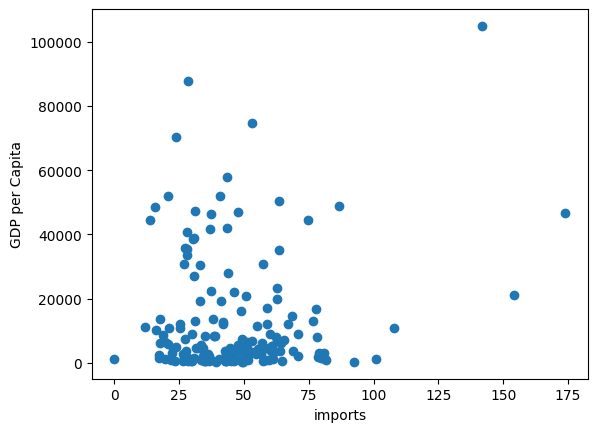

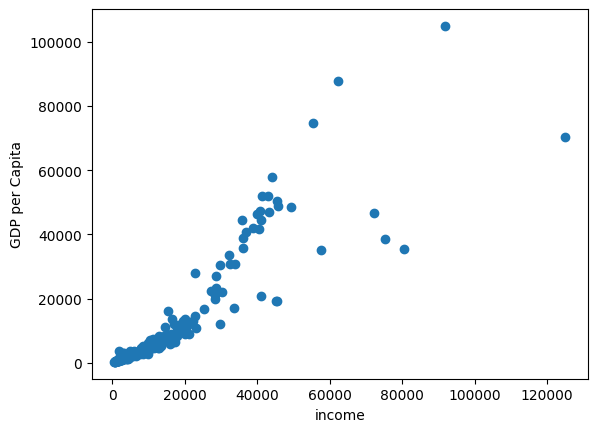

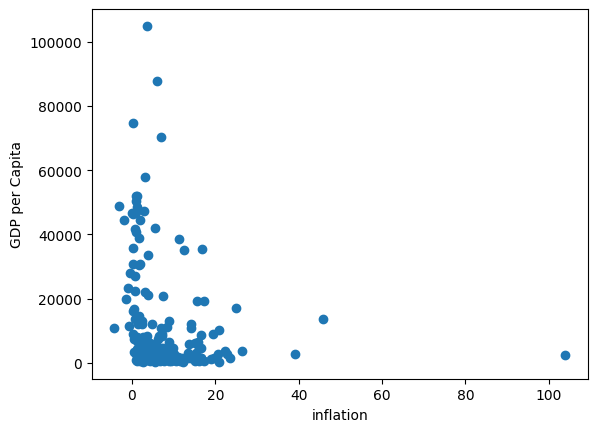

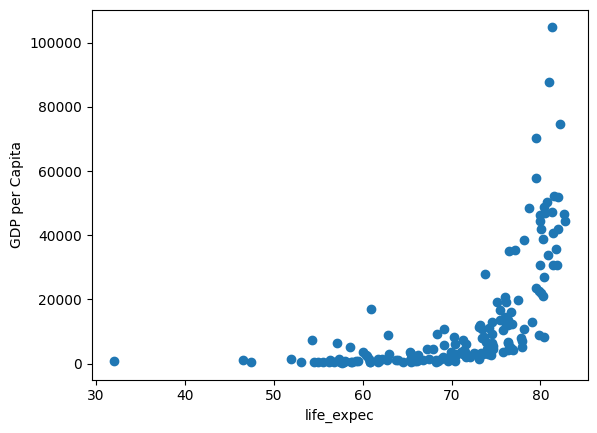

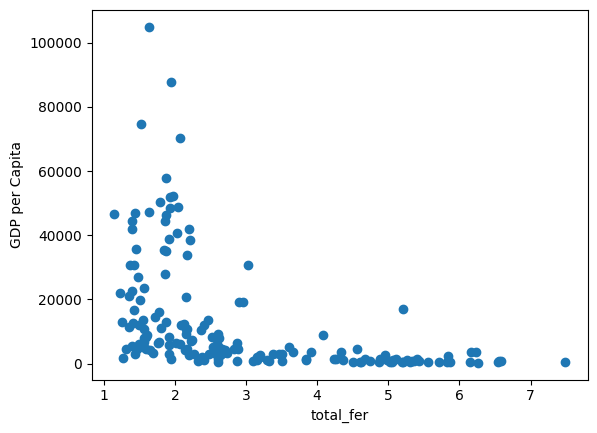

In [314]:
# Explore the continuous independent features against gdpp using scatter plots.
for f in df.columns[:-1]:  # Exclude 'gdpp'
  plt.scatter(df[f], df['gdpp'])
  plt.xlabel(f)
  plt.ylabel('GDP per Capita')
  plt.show()

It seems like exports, health, imports and total_fert may be best suited for separating into clusters.

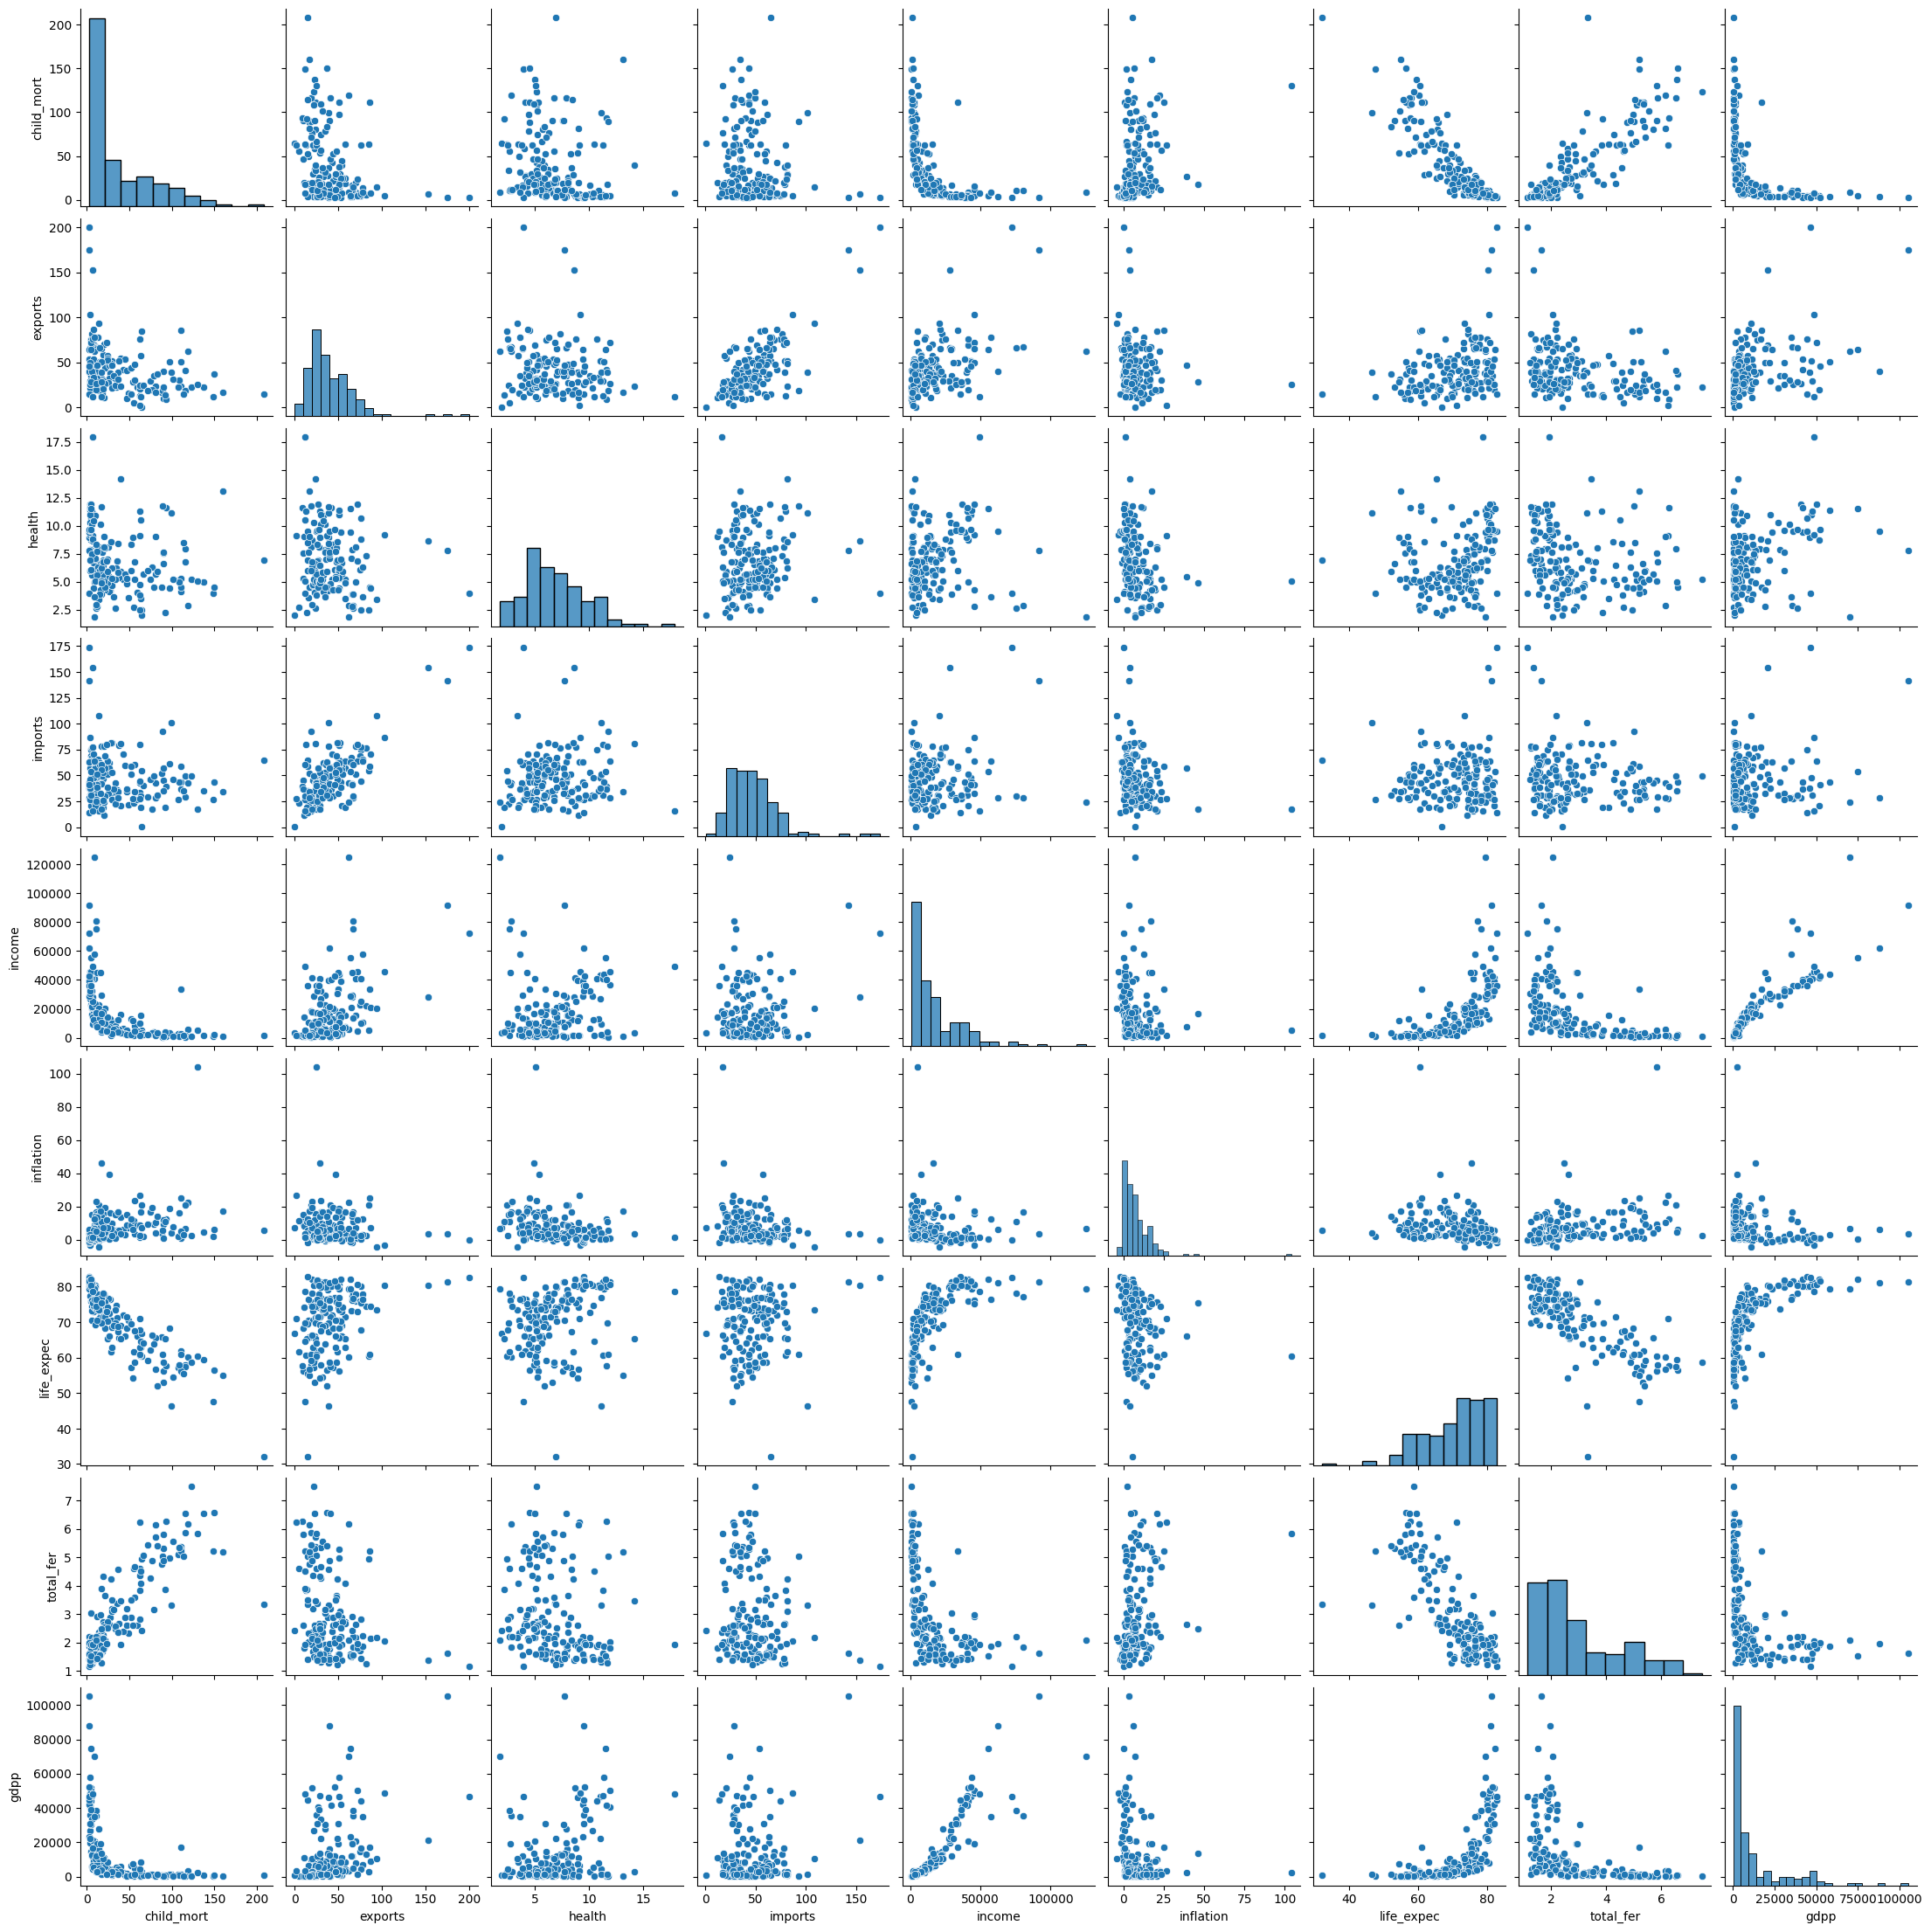

In [315]:
# Create a pair plot
# Hint: Explore seaborn pairplot
sns.pairplot(df)
plt.show()

Note the peaks in the diagonal graphs that are distinct from each other or only overlap slightly. Looking at the scatter plot distributions may also give you some indication of features that would be good candidates for clustering the data.

### Scaling the Data

In [316]:
# Normalise the data using MinMaxScaler
# Name the normalised dataframe "df_scaled"
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Transforming numpy array back into pandas dataframe
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242


## K-Means Clustering

### Selecting K

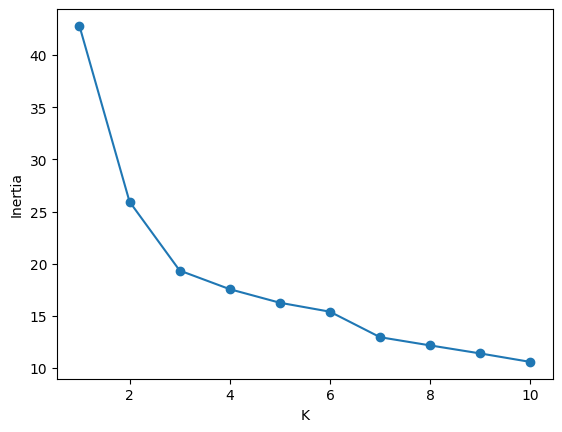

In [317]:
# Plot elbow curve
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
    kmeans.fit(x)
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=42):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, 11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

# Plot elbow curve using scaled dataset
elbow_Kmeans(df_scaled)

Optimal number of clusters is either 3 or 4.

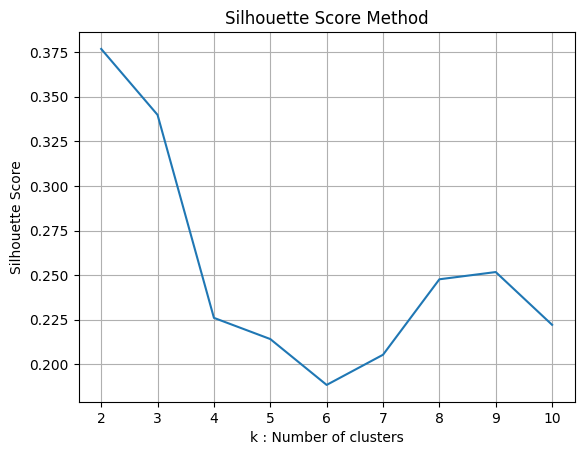

In [318]:
# Silhouette score method
kmax = 10
sil = []
plt.plot()
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=rseed, max_iter=500)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_scaled, labels, metric='euclidean'))

sns.lineplot(x=range(2, kmax+1), y=sil)
plt.title('Silhouette Score Method')
plt.xlabel('k : Number of clusters')
plt.ylabel("Silhouette Score")
plt.grid(visible=True)
plt.show()

Based on the elbow and silhouette score method choose a value for K.

Elbow method suggested 3 or 4 clusters was best. Silhouette score confirmed that 3 is best.

## Fitting a K-Means Model with the selected K value

In [319]:
# Remember to set the random_state to rseed
kmeans = KMeans(n_clusters=3, random_state=rseed)
kmeans.fit(df_scaled)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [320]:
# Converting numpy array to pandas dataframe
labels  = pd.DataFrame(kmeans.labels_, columns= ['labels'])

In [321]:
# Count the number of records in each cluster
labels.value_counts()

labels
0         87
2         45
1         35
Name: count, dtype: int64

In [322]:
# Check model performance with the silhouette coefficient
silhouette_avg = silhouette_score(df_scaled, labels)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.33976487765323604


c:\Users\amylo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Predictions

In [323]:
# Add the predicted cluster label column to the original dataframe
df_scaled = pd.concat([df_scaled, labels], axis=1)
df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,labels
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073,2
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833,0
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365,0
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488,2
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242,0


## Visualisation of clusters

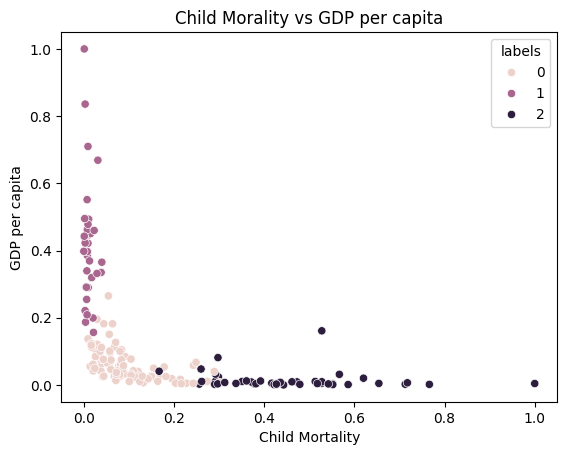

In [324]:
# Visualisation of clusters: child mortality vs gdpp
sns.scatterplot(data=df_scaled, x='child_mort', y='gdpp', hue='labels')
plt.title("Child Morality vs GDP per capita")
plt.ylabel("GDP per capita")
plt.xlabel("Child Mortality")
plt.show()

Child mortality appears linked to low(er) GDP per capita.

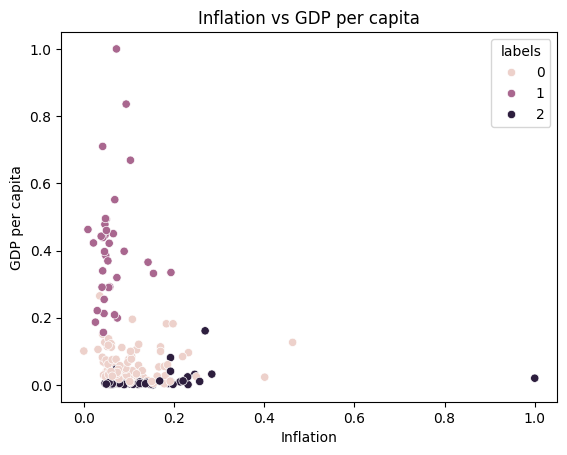

In [326]:
# Visualisation of clusters: inflation vs gdpp
sns.scatterplot(data=df_scaled, x='inflation', y='gdpp', hue='labels')
plt.title("Inflation vs GDP per capita")
plt.ylabel("GDP per capita")
plt.xlabel("Inflation")
plt.show()

## Interpreting and analysing clusters

In [327]:
# Cluster characteristics
df_scaled.groupby('labels').mean()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
labels,,,,,,,,,
0,0.096839,0.201990,0.275476,0.271713,0.096755,0.109138,0.796005,0.183854,0.061339
1,0.011184,0.291771,0.441730,0.295760,0.363321,0.062333,0.949620,0.093240,0.409340
2,0.448556,0.143746,0.278392,0.243711,0.023687,0.151784,0.537322,0.624465,0.014068


In [328]:
# Name clusters/labels
cluster_names = {
    0: 'Middle Income',
    1: 'High Income',
    2: 'Low Income'
}

# Map cluster names to 'labels' column
df_scaled['labels'] = df_scaled['labels'].map(cluster_names)

In [329]:
df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,labels
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073,Low Income
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833,Middle Income
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365,Middle Income
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488,Low Income
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242,Middle Income


## Conclusions

Label the groups of countries in the plots you created based on child mortality, GDPP and inflation. You may use [terms](https://en.wikipedia.org/wiki/Developing_country#Terms_used_to_classify_countries) such as: least developed, developing and developed, or low, low-middle, upper-middle and high income. Alternatively, simply rank them from highest to lowest. Justify the labels you assign to each group.


**Answer here:**

I chose to label cluster group 0 as 'Middle Income' because this group of countries seemed to have the middle income of the 3 clusters.

I labeled cluster group 1 as 'High Income' because this group of countries had by far the highest GDP per capita. This group of countries has the lowest child mortality rate. This is likely linked to the wealthier countries as these countries typically have better healthcare options.


I marked cluster group 2 as 'Low Income' because this group of countries has the lowest GDP per capita. These countries also have higher child mortality rates.